## Evaluating the model's performance and ability to estimate uncertainty

This example shows how to use the uncertainty visualization tools and metrics proposed in this thesis

In [1]:
from tqdm.notebook import tqdm
# Clone the repository and install the requirementes file
!git clone "https://github.com/davidserra9/UncertaintyProxy.git"

import sys
import os
from os.path import join
sys.path.insert(0, join(os.getcwd(), "UncertaintyProxy"))

# GPU
import torch
print("\nAvailable GPU: ")
torch.cuda.get_device_name(torch.cuda.current_device())


Cloning into 'UncertaintyProxy'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 209 (delta 121), reused 144 (delta 59), pack-reused 0
Receiving objects: 100% (209/209), 16.06 MiB | 3.47 MiB/s, done.
Resolving deltas: 100% (121/121), done.

Available GPU: 


/home/david/miniconda3/envs/TFM/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NVIDIA GeForce RTX 3060'

Load the model

In [2]:
# Load the trained model
from UncertaintyProxy.utils.NN_utils import *

MODEL = "efficientnet_b0"
DEVICE = "cuda"
SPECIES = ["Spatangus purpureus",
           "Echinaster sepositus",
           "Cerianthus membranaceus",
           "Bonellia viridis",
           "Scyliorhinus canicula",
           "Ophiura ophiura",
           "Background"]

model = initialize_model(model_name=MODEL,
                         num_classes=len(SPECIES),
                         load_model=True,
                         model_root=".")
model = model.eval()
model = model.to(DEVICE)

Model loaded from ./efficientnet_b0.pth.tar
+-----------------+-------+----------+----------+
|  architecture   | epoch | accuracy | f1 score |
+-----------------+-------+----------+----------+
| efficientnet_b0 |  16   |  0.837   |  0.827   |
+-----------------+-------+----------+----------+


Create the Dataset and Dataloader pytorch objects. The Dataset object is customized to work with the ICM-20.1 dataset showing the number of annotations split in marine species.

In [3]:
from torch.utils.data import DataLoader
from utils.UW_dataset import UWDataset
import matplotlib.pyplot as plt

test_dataset = UWDataset(split_list=["/media/david/media/TFM/dataset/images/test_images"],
                             list_classes=SPECIES,
                             train=False)

test_loader = DataLoader(test_dataset,
                         batch_size=12,
                         num_workers=8,
                         pin_memory=True)


Splits: ['test_images']
5 frames per annotation
+---------+----------+----------+----------+--------------+---------+----------+
| Spatang | Echinast | Cerianth | Bonellia | Scyliorhinus | Ophiura | Backgrou |
|   us    |    er    |    us    |          |              |         |    nd    |
+---------+----------+----------+----------+--------------+---------+----------+
|   213   |   262    |   104    |    63    |      38      |   26    |   256    |
+---------+----------+----------+----------+--------------+---------+----------+


Plot Confusion Matrix

Confusion Matrix: 100%|█████████████████████████| 81/81 [03:28<00:00,  2.57s/it]


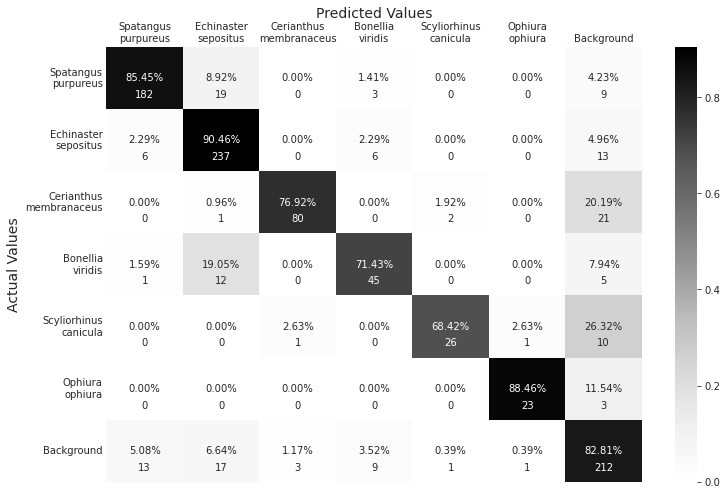

In [4]:
from UncertaintyProxy.utils.inference_utils import confusion_matrix_fn

fig = confusion_matrix_fn(model=model,
                          loader=test_loader,
                          list_classes=SPECIES,
                          device=DEVICE)

Uncertainty estimations using the Monte Carlo dropout wrapper

In [5]:
import numpy as np
from UncertaintyProxy.utils.MCdropout_wrapper import MCDP_model
from UncertaintyProxy.utils.uncertainty_metrics import predictive_entropy, uncertainty_box_plot, uncertainty_curve

mc_samples = 10

mc_wrapper = MCDP_model(model=model,
                        num_classes=len(SPECIES),
                        device=DEVICE,
                        mc_samples=mc_samples)

dropout_predictions = np.empty((0, mc_samples, next(iter(test_loader))[0].shape[1], len(SPECIES)))
true_y = np.array([], dtype=np.uint8)

# Iterate over the loader and stack all the batches predictions
for (batch, target) in tqdm(test_loader, desc="Uncertainty with MC Dropout"):
    batch, target = batch.to(DEVICE), target.to(DEVICE)
    outputs = mc_wrapper(batch)  # (batch_size, mc_samples, images_per_annotations, num_classes)
    dropout_predictions = np.vstack((dropout_predictions, outputs))
    true_y = np.append(true_y, target.cpu().numpy())

# Mean and std of the MC predictions
mean = np.mean(dropout_predictions, axis=1)
std = np.std(dropout_predictions, axis=1)

pred_y = mean.max(axis=1).argmax(axis=-1)
pred_std = std[np.arange(mean.shape[0]), mean.max(axis=2).argmax(axis=-1), mean.max(axis=1).argmax(axis=-1)]
pred_entropy = predictive_entropy(mean)

Uncertainty with MC Dropout: 100%|██████████████| 81/81 [03:31<00:00,  2.61s/it]


Plot box plots and histograms of the predictions divided in correct and incorrect samples. The correct samples should have lower uncertainty values.

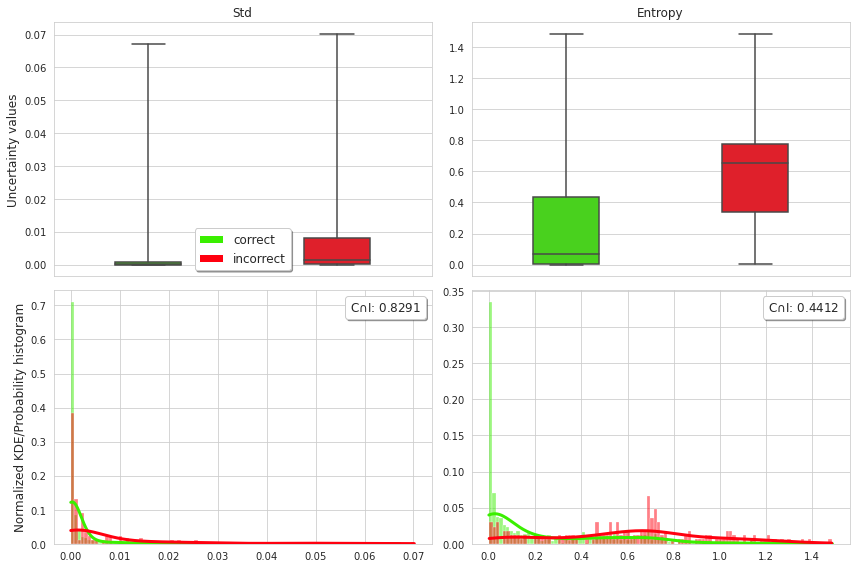

In [6]:
fig = uncertainty_box_plot(y_true=true_y, y_pred=pred_y, std=pred_std, entropy=pred_entropy)

Plot the Uncertainty Ordering Curve.

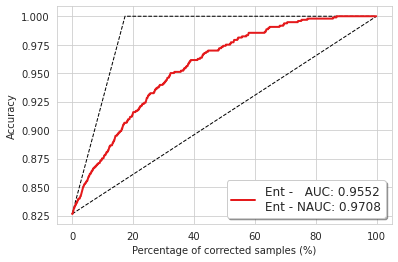

In [7]:
fig = uncertainty_curve(y_true=true_y, y_pred=pred_y, ent=pred_entropy)